# In this notebook I develop several heuristics for rating the quality of the shots.

In [79]:
import numpy as np
import sqlite3
import MDSplus as mds
import scipy.fftpack as fft
from scipy.signal import periodogram

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

In [3]:
bias_current_node_name = '\j_002_004'
fiducial_a_node_name = '\j_002_001'
fiducial_b_node_name = '\j_002_004'

#no_oscillation
#short_oscillation
#long_scillation

# Bias current heuristics

I want to determine:
1. the peak current
2. the crowbar time
3. the noise in the pre-ramp phase of the signal 

In [4]:
connection = sqlite3.connect('shots.db')
connection.row_factory = sqlite3.Row
cursor = connection.cursor()
cursor.execute("SELECT * FROM Shots")
rows = cursor.fetchall()
cursor.close()
connection.close()
first_shot = rows[0]

In [5]:
tree = mds.Tree('rsx', first_shot['shot'])
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3


## Typical bias current trace

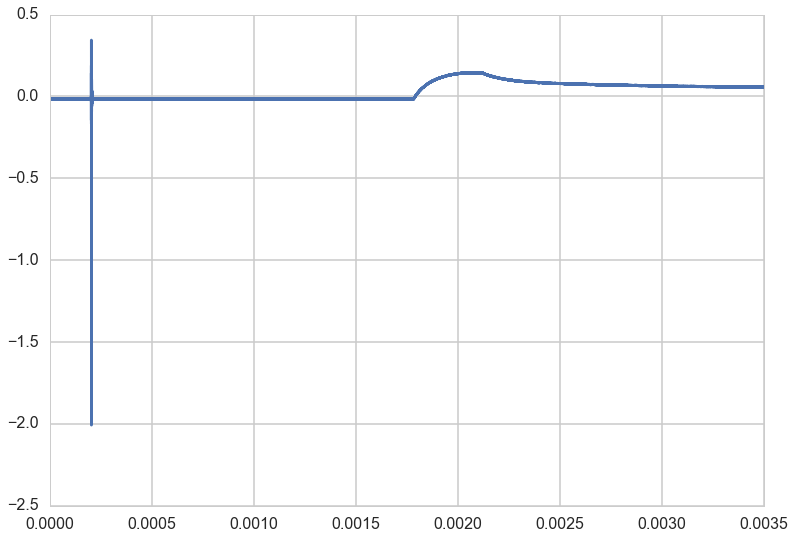

In [6]:
plt.plot(bias_current_time, bias_current)

### Typical bias current noise. I can take the standard devation as a measure of the noise

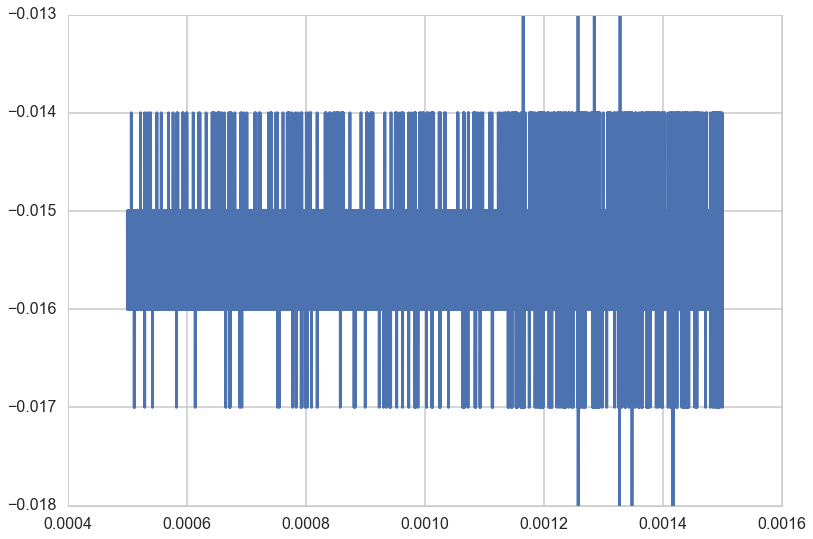

In [7]:
plt.plot(bias_current_time[10000:30000], bias_current[10000:30000])

## Determine peak current

To determine the peak current I smooth the bias current trace with a boxcar filter and take the max.
The choice of baxcar width is important I don't want it to be too wide, since that reduces the peak but also not to short since then noise could be misinterperted as the peak.

In [8]:
tree = mds.Tree('rsx', 15409)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

39991 40000 39991
39991 40000


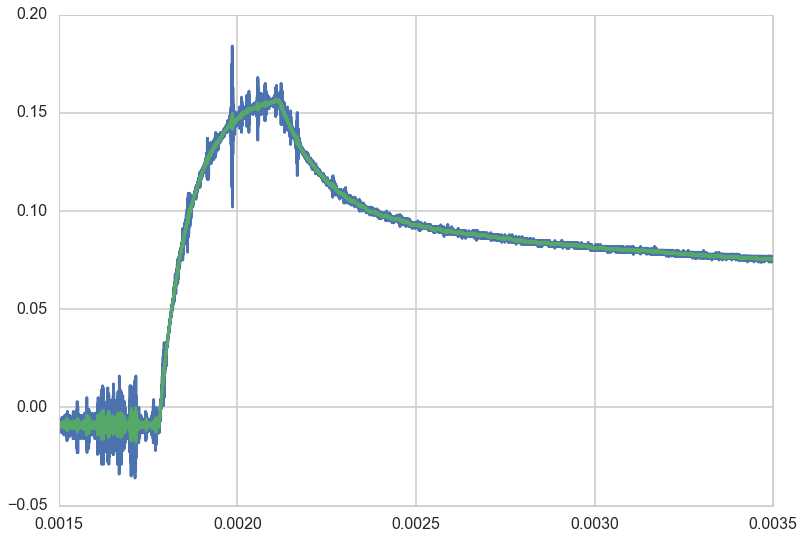

In [9]:
signal_to_filter = bias_current[30000:]
time_to_filter = bias_current_time[30000:]

window_len = 10
w = np.ones(window_len,'d')
y=np.convolve(w/w.sum(), signal_to_filter ,mode='valid')
print y.size, signal_to_filter.size, time_to_filter[4:-5].size
plt.plot(time_to_filter, signal_to_filter)
plt.plot(time_to_filter[4:-5], y)
print y.size, signal_to_filter.size

### N.B. This is a noiser shot the pre-ramp phase has a higher standard deviation.

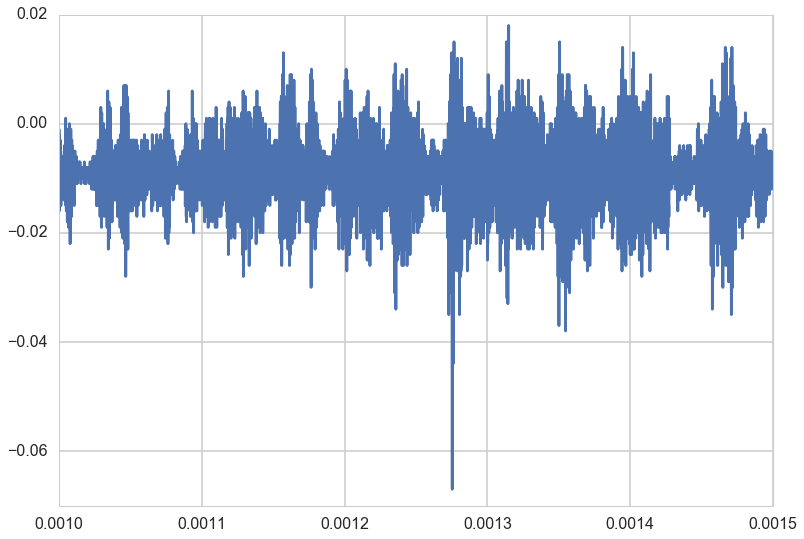

In [10]:
plt.plot(bias_current_time[20000:30000], bias_current[20000:30000])

In [11]:
tree = mds.Tree('rsx', 15416)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

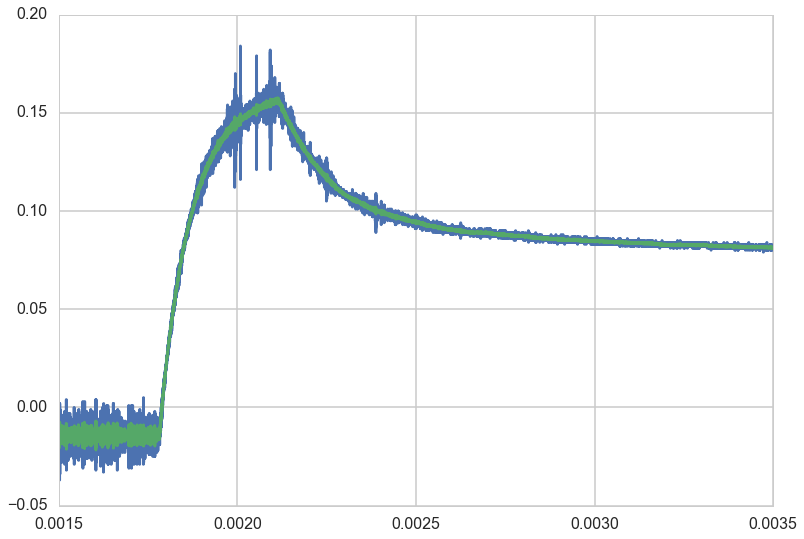

In [12]:
signal_to_filter = bias_current[30000:]
time_to_filter = bias_current_time[30000:]

window_len = 10
w = np.ones(window_len, 'd')
y=np.convolve(w/w.sum(), signal_to_filter ,mode='valid')
plt.plot(time_to_filter, signal_to_filter)
plt.plot(time_to_filter[4:-5], y)


In [13]:
tree = mds.Tree('rsx', 15420)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

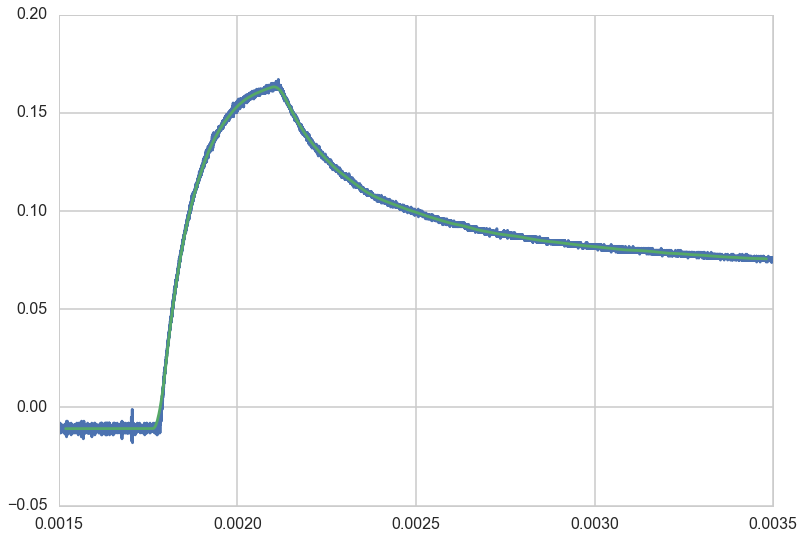

In [14]:
signal_to_filter = bias_current[30000:]
time_to_filter = bias_current_time[30000:]

window_len = 750
w = np.ones(window_len,'d')
y=np.convolve(w/w.sum(), signal_to_filter ,mode='valid')
plt.plot(time_to_filter, signal_to_filter)
plt.plot(time_to_filter[374:-375], y)

## To identify the crowbar time I want to look at the zerocrossing of the derivative. I use a much stronger filter to make the derivatives smooth, since differentiating amplifies noise.

40000 40000 39251
40000 40000


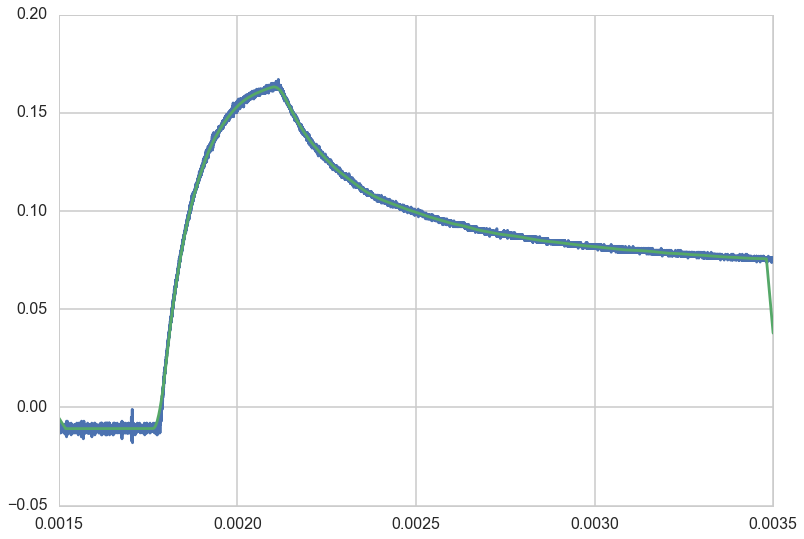

In [15]:
signal_to_filter = bias_current[30000:]
time_to_filter = bias_current_time[30000:]

window_len = 750
w = np.ones(window_len,'d')
y=np.convolve(w/w.sum(), signal_to_filter ,mode='same')
print y.size, signal_to_filter.size, time_to_filter[374:-375].size
plt.plot(time_to_filter, signal_to_filter)
plt.plot(time_to_filter, y)
print y.size, signal_to_filter.size

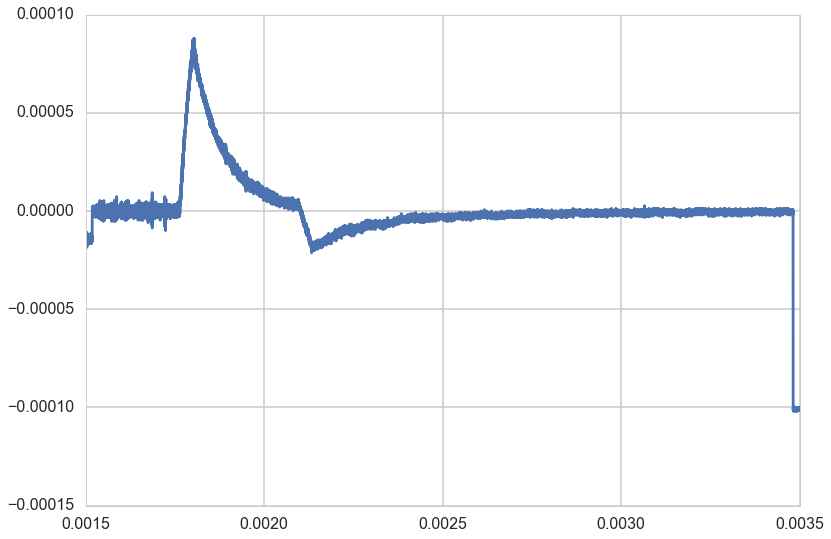

In [16]:
plt.plot(time_to_filter, np.gradient(y))

### I add a small offset to the derivative to make it easier to differentiate the zero-crossing from samller ones induced by noise 

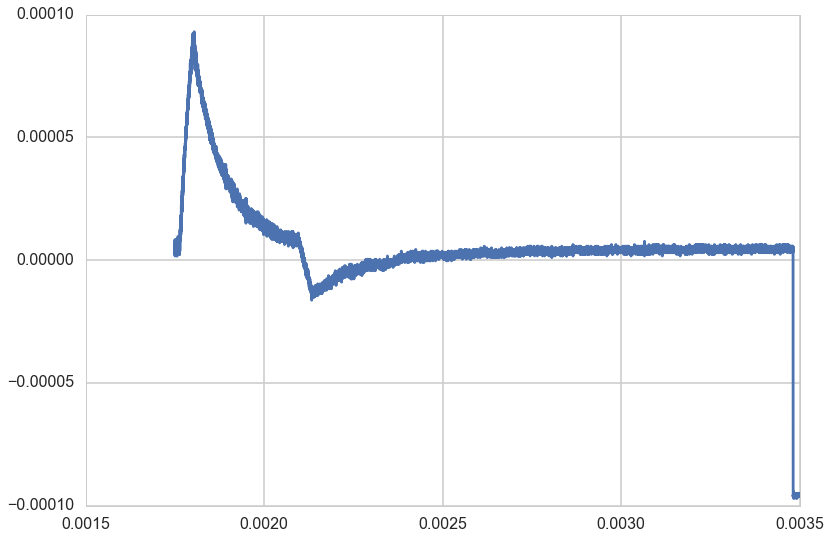

In [17]:
plt.plot(time_to_filter[5000:], np.gradient(y)[5000:]+0.000005)

In [18]:
np.where(np.diff(np.sign(np.gradient(y[6000:]+0.000005))))[0]

array([ 6004,  6005,  6006, ..., 33618, 33619, 33621])

In [19]:
time_to_filter[499:-500][6000:][5629]

0.0021064002

# Develop gyration heursitics

## Plan look at fft of fiducial, record signal strength, and time window at which frequency starts

### First what is the distribution of periods determined by Jason's Script

In [20]:
connection = sqlite3.connect('shots.db')
cursor = connection.cursor()
cursor.execute('SELECT period FROM Shots WHERE fiducial_a_signal_exists=1 AND bias_current_signal_exists=1')
periods = cursor.fetchall()

In [21]:
cleaned_periods = []
for period in periods:
    if period[0] == None:
        pass
    else:
        cleaned_periods.append(period[0])
cleaned_periods = np.asarray(cleaned_periods)    

In [22]:
cleaned_periods.size

2095

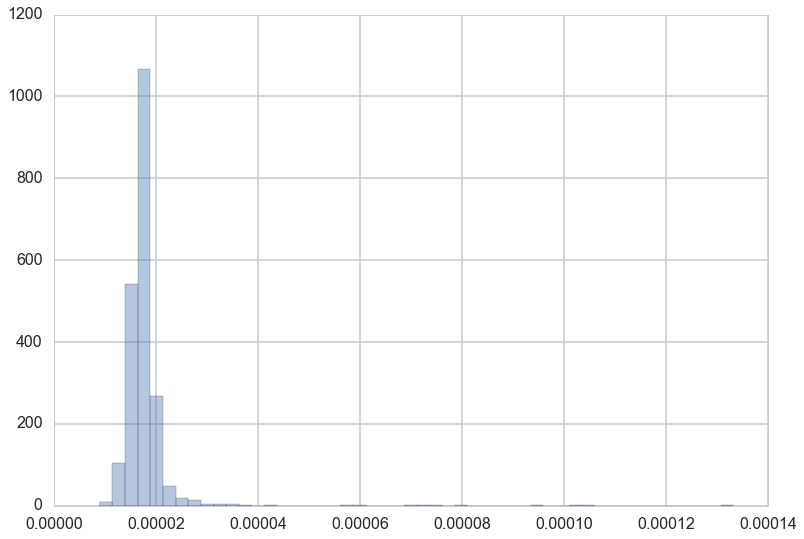

In [23]:
sns.distplot(cleaned_periods, norm_hist=False, kde=False)

In [24]:
cleaned_periods.mean()

1.7753055709056326e-05

In [25]:
cleaned_periods.std()

5.5611730431042248e-06

### Look at amplitudes

/Users/vonderlinden2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/vonderlinden2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


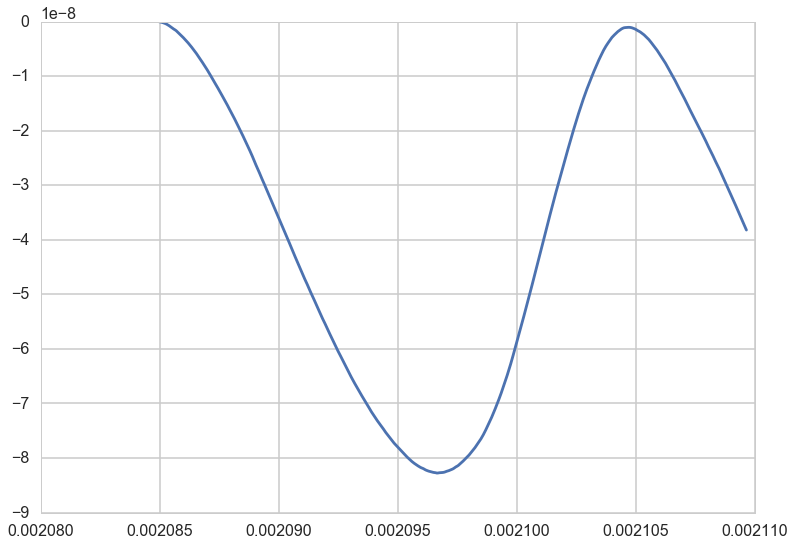

In [109]:
connection = sqlite3.connect('shots.db')
connection.row_factory = sqlite3.Row
cursor = connection.cursor()
cursor.execute('SELECT * FROM Shots WHERE fiducial_a_signal_exists=1 AND bias_current_signal_exists=1')
good_shots = cursor.fetchall()
shots_list = [good_shots[0]]
for shot in shots_list:
    shot_number = shot['shot']
    zero_phase_index = shot['zero_phase_index']
    if shot['period'] == None:
        continue
    else:
        period = shot['period']
    fiducial_a_node_name = shot['fiducial_a_node']
    rsx_tree = mds.Tree('rsx', shot_number)
    fiducial_a_data = rsx_tree.getNode(fiducial_a_node_name).getData()
    fiducial_a_signal = np.asarray(fiducial_a_data.getValue())
    fiducial_a_time = np.asarray(fiducial_a_data.getDimensions()[0])*1e-3
    time_step = fiducial_a_time[1] - fiducial_a_time[0]
    start_index = zero_phase_index
    end_index = zero_phase_index + np.ceil(period/time_step)*1.25
    zero = np.mean(fiducial_a_signal[:500])
    integral = cumtrapz(fiducial_a_signal[start_index:end_index]-zero, dx=time_step, initial=0)
    #plt.plot(fiducial_time[start_index:end_index], fiducial_a_signal[start_index:end_index]-zero)
    plt.plot(fiducial_time[start_index:end_index], integral)
    plt.show()
    

### Distribution of Frequencies

The distribution is approximatly Gaussian with a small bump.

In [26]:
import numpy as np
from scipy.optimize import curve_fit

def fit_func_gauss_poly(x, a0, a1, a2, a3, a4, a5):
    z = (x - a1) / (np.sqrt(2)*a2)
    y = a0 * np.exp(-z**2) + a3 + a4 * x + a5 * x**2
    return y

In [27]:
import numpy as np
from scipy.optimize import curve_fit

def fit_func_pure_gauss(x, a0, a1, a2, a3):
    z = (x - a1) / (np.sqrt(2)*a2)
    y = a0 * np.exp(-z**2) + a3
    return y

In [28]:
cleaned_frequencies = 1/cleaned_periods

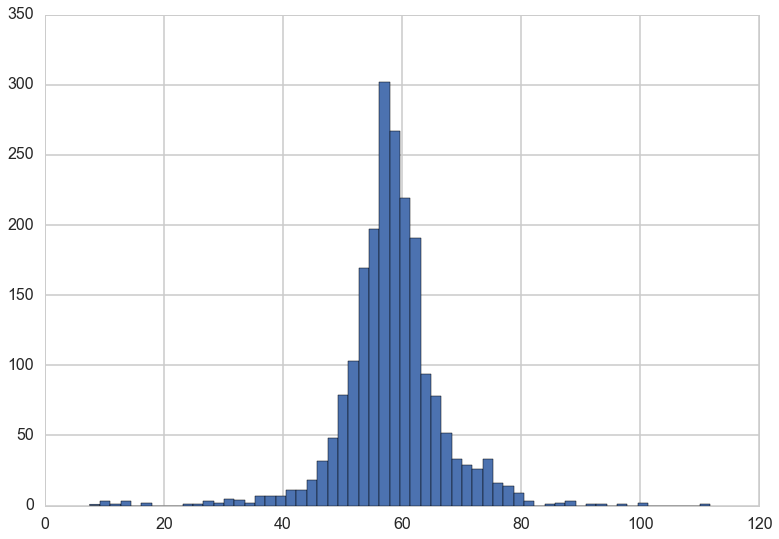

In [29]:
n, bins, patches = plt.hist(cleaned_frequencies/1000, 60)

In [30]:
bins[:-1] + np.diff(bins)/2

array([   8.37604331,   10.11311545,   11.8501876 ,   13.58725974,
         15.32433188,   17.06140402,   18.79847616,   20.5355483 ,
         22.27262044,   24.00969259,   25.74676473,   27.48383687,
         29.22090901,   30.95798115,   32.69505329,   34.43212543,
         36.16919758,   37.90626972,   39.64334186,   41.380414  ,
         43.11748614,   44.85455828,   46.59163042,   48.32870257,
         50.06577471,   51.80284685,   53.53991899,   55.27699113,
         57.01406327,   58.75113541,   60.48820755,   62.2252797 ,
         63.96235184,   65.69942398,   67.43649612,   69.17356826,
         70.9106404 ,   72.64771254,   74.38478469,   76.12185683,
         77.85892897,   79.59600111,   81.33307325,   83.07014539,
         84.80721753,   86.54428968,   88.28136182,   90.01843396,
         91.7555061 ,   93.49257824,   95.22965038,   96.96672252,
         98.70379466,  100.44086681,  102.17793895,  103.91501109,
        105.65208323,  107.38915537,  109.12622751,  110.86329

In [31]:
n

array([   1.,    3.,    1.,    3.,    0.,    2.,    0.,    0.,    0.,
          1.,    1.,    3.,    2.,    5.,    4.,    2.,    7.,    7.,
          7.,   11.,   11.,   18.,   32.,   48.,   79.,  103.,  169.,
        197.,  302.,  267.,  219.,  191.,   94.,   78.,   52.,   33.,
         29.,   26.,   33.,   16.,   14.,    9.,    3.,    0.,    1.,
          2.,    3.,    0.,    1.,    1.,    0.,    1.,    0.,    2.,
          0.,    0.,    0.,    0.,    0.,    1.])

In [32]:
parameters, covariance = curve_fit(fit_func_pure_gauss, bins[:-1] + np.diff(bins)/2, n, p0=[300, 60, 10, 1e-3])

In [33]:
parameters

array([ 261.96058784,   57.98936271,    4.71437588,    5.21498807])

In [1]:
sns.distplot(cleaned_frequencies/1000, norm_hist=False, kde=False, axlabel='Frequency [kHz]')
plt.plot(np.linspace(0, 120, 200), fit_func_pure_gauss(np.linspace(0, 120, 200), *parameters), color='darkblue')

NameError: name 'sns' is not defined

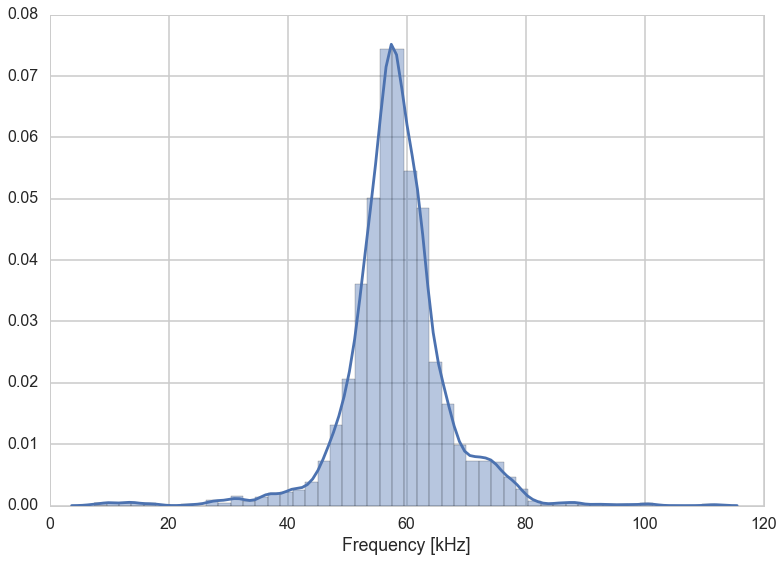

In [35]:
sns.distplot(cleaned_frequencies/1000, norm_hist=False, axlabel='Frequency [kHz]')

In [36]:
cleaned_frequencies.mean()

58254.056383850373

In [37]:
cleaned_frequencies.std(ddof=1)

8388.436120787459

### The gryration frquency over the 3000 shots is $f=58kHz \pm 8kHz$

In [38]:
print "The mean oscillation frequency is %(freq)5.2e" % {'freq': 1/cleaned_periods.mean()}

The mean oscillation frequency is 5.63e+04


In [39]:
print ("68 percent of the frequency measuremnts lie between %(low)5.2e and %(high)5.2e" % 
       {'low': 1/(cleaned_periods.mean() - cleaned_periods.std()),
        'high': 1/(cleaned_periods.mean() + cleaned_periods.std())})

68 percent of the frequency measuremnts lie between 8.20e+04 and 4.29e+04


## Let's look at the frequency spectrum of a shot with gyration (15432) and one without (15557)

In [40]:
tree = mds.Tree('rsx', 15423)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_with_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3

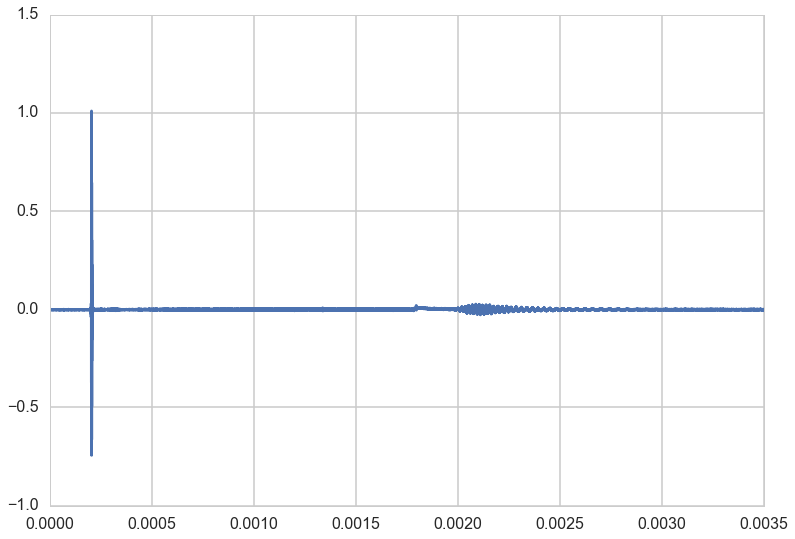

In [41]:
plt.plot(fiducial_time, fiducial_with_oscillation)

## Taking a fft of the whole signal the peak around 56kHz in spectrum is noticeable

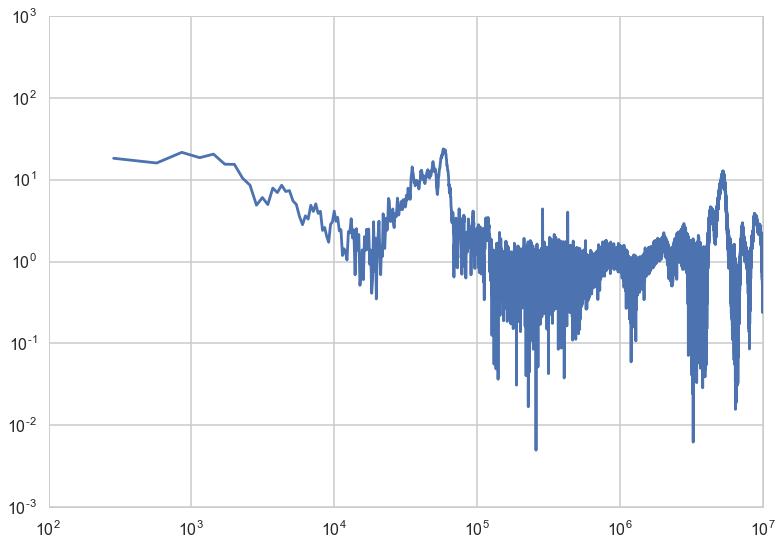

In [42]:
size = fiducial_with_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.loglog(freqs[midpoint:], np.abs(fft.fftshift(fft.fft(fiducial_with_oscillation))[midpoint:]))

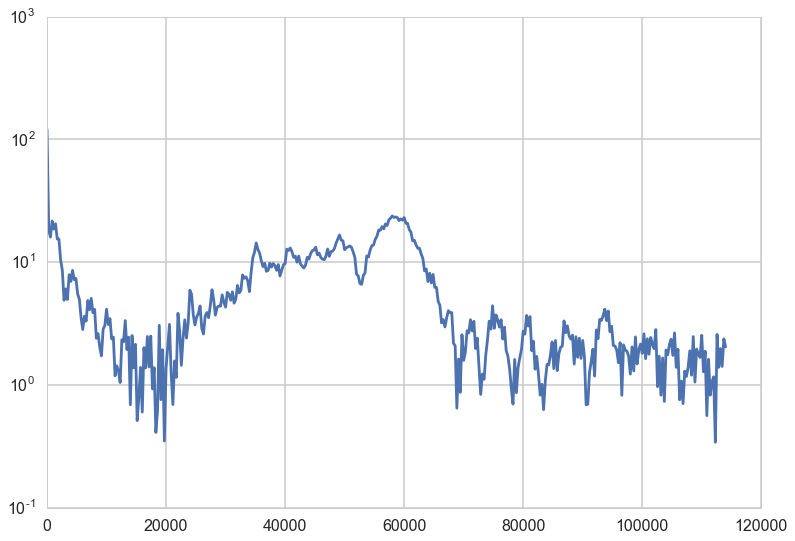

In [43]:
size = fiducial_with_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+400], np.abs(fft.fftshift(fft.fft(fiducial_with_oscillation))[midpoint:midpoint+400]))


## Does the gyration peak become more pronounced if we only look at the time window after the current ramps up

In [44]:
from scipy.signal import blackman

In [45]:
window_with_oscillation = fiducial_with_oscillation[35500:60000]

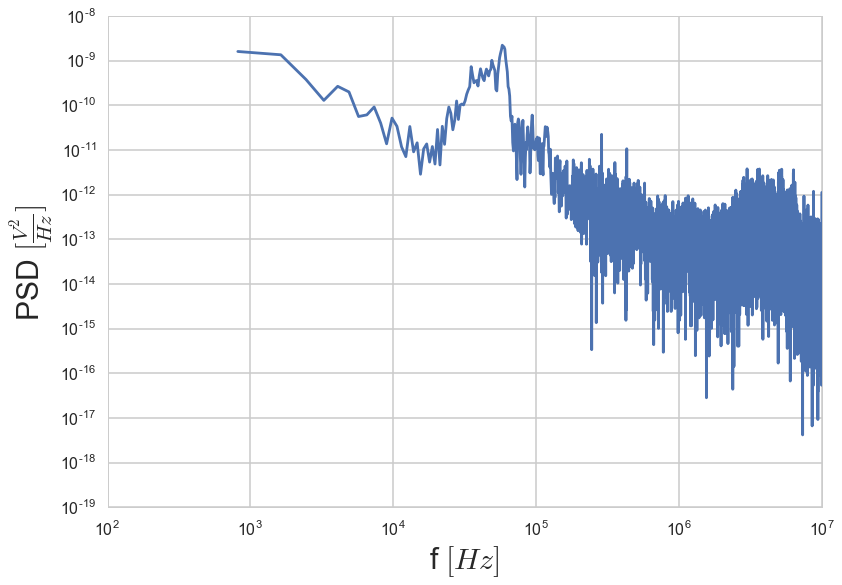

In [80]:
size = window_with_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
freqs, psd = periodogram(window_with_oscillation, 1/(fiducial_time[1]-fiducial_time[0]))
plt.loglog(freqs, psd)
plt.ylim((10**-19, 10**-8))
plt.ylabel(r'PSD $[\frac{V^2}{Hz}]$', fontsize=30)
plt.xlabel(r'f $[Hz]$', fontsize=30)
plt.show()

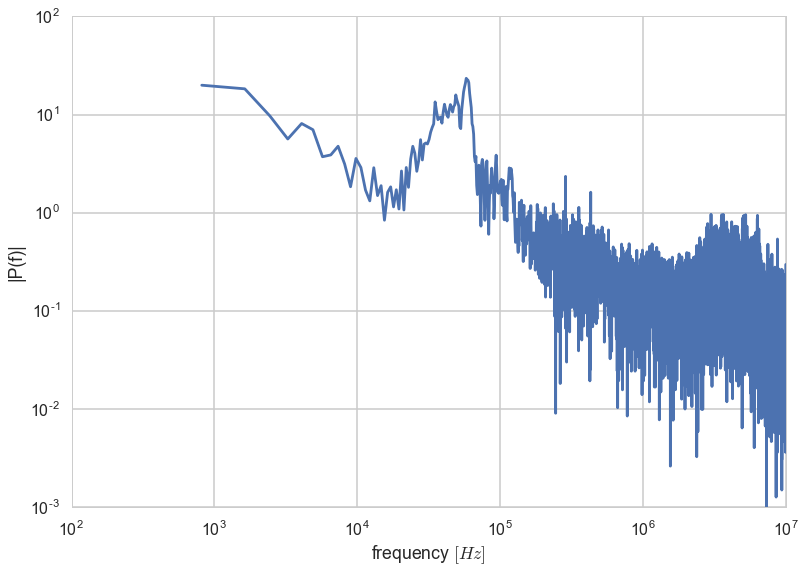

In [81]:
size = window_with_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.loglog(freqs[midpoint:], np.abs(fft.fftshift(fft.fft(window_with_oscillation))[midpoint:]))
plt.ylabel(r'|P(f)|')
plt.xlabel(r'frequency $[Hz]$')

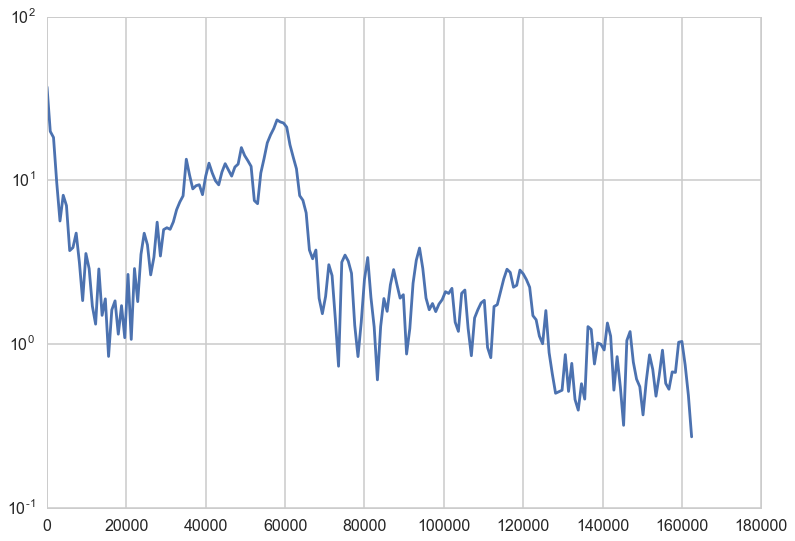

In [82]:
size = window_with_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+200], np.abs(fft.fftshift(fft.fft(window_with_oscillation))[midpoint:midpoint+200]))

## Let's see if multiplying by a window function helps remove some other frequencies which might be due to edge effects.

In [83]:
windowed = blackman(40000)*fiducial_with_oscillation[20000:60000]
#windowed = fiducial[30000:60000]
#windowed = np.pad(windowed, 100000, mode='symmetric')

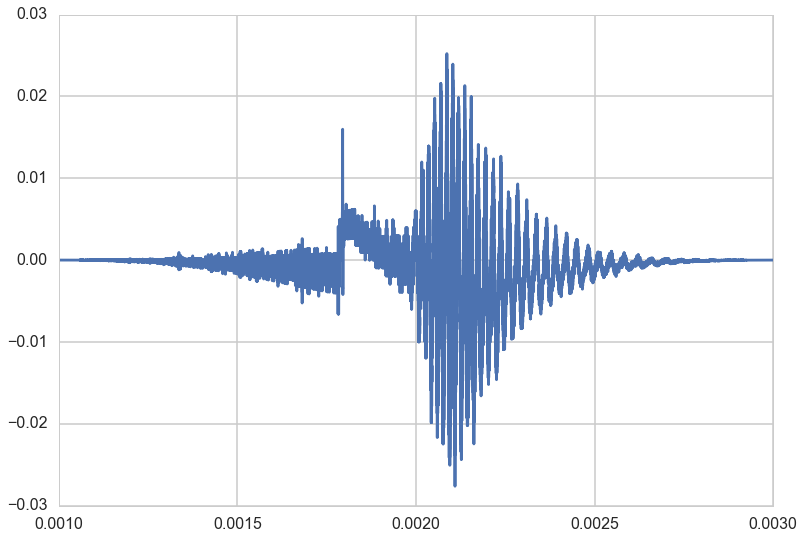

In [84]:
plt.plot(fiducial_time[20000:60000], windowed)

### The spectrum is not much clearer I will not use a window function

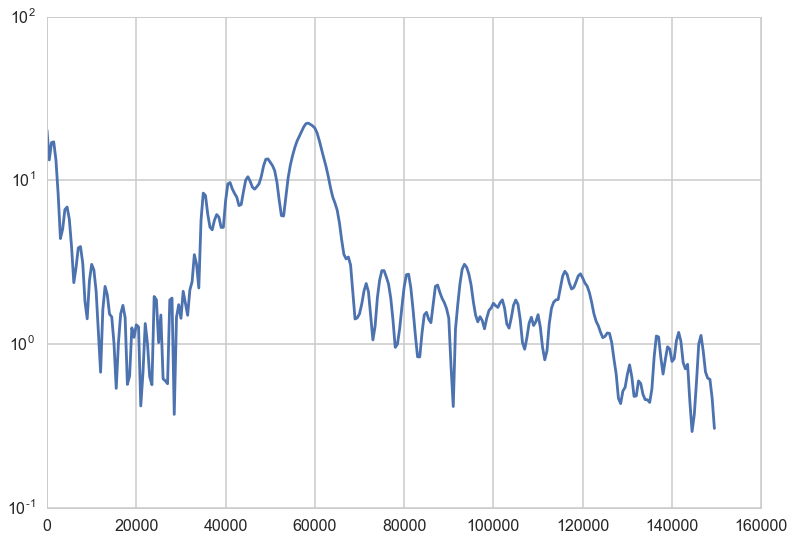

In [85]:
size = windowed.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+300], np.abs(fft.fftshift(fft.fft(windowed))[midpoint:midpoint+300]))

## Let's look at a shot without gyration or only a weak gyration

In [86]:
tree = mds.Tree('rsx', 15557)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_wo_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3

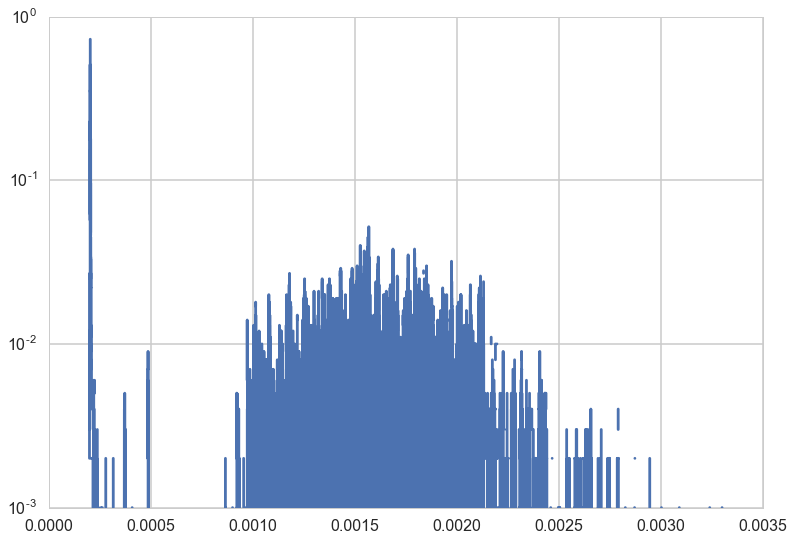

In [87]:
plt.semilogy(fiducial_time, fiducial_wo_oscillation)

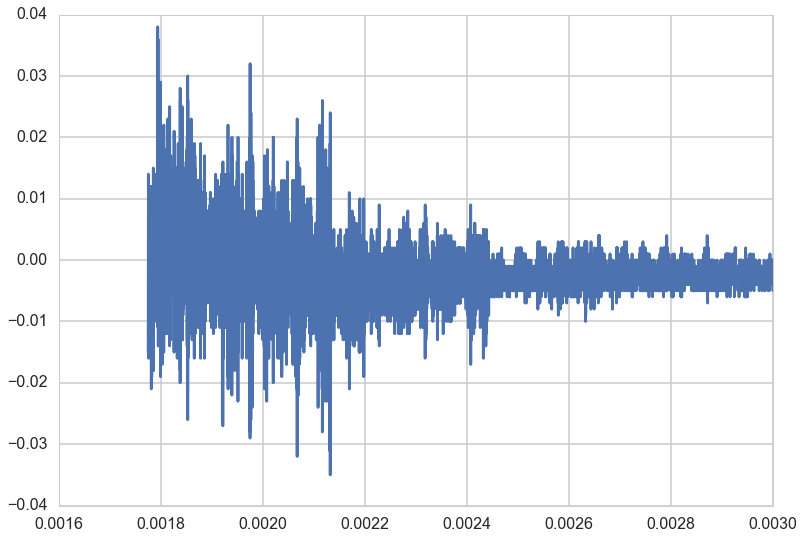

In [88]:
window_wo_oscillation = fiducial_wo_oscillation[35500:60000]
plt.plot(fiducial_time[35500:60000], window_wo_oscillation)

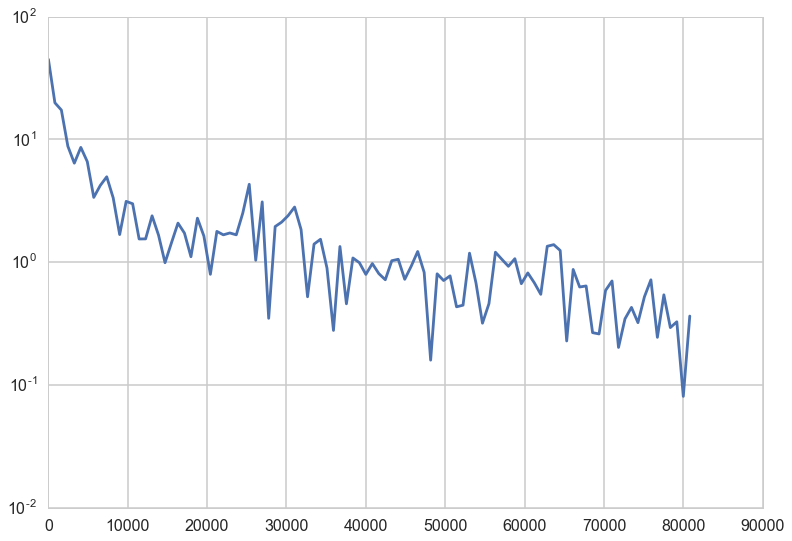

In [89]:
size = window_wo_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+100], np.abs(fft.fftshift(fft.fft(window_wo_oscillation))[midpoint:midpoint+100]))

## Good, there is an order of magnitude difference in spectrum of shots which gyrate and those that don't

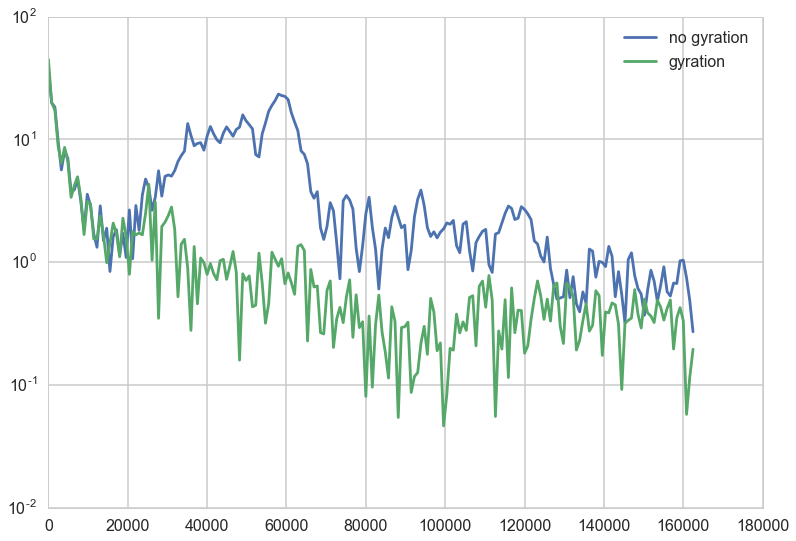

In [90]:
size = window_with_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+200], np.abs(fft.fftshift(fft.fft(window_with_oscillation))[midpoint:midpoint+200]), label='no gyration')
plt.semilogy(freqs[midpoint:midpoint+200], np.abs(fft.fftshift(fft.fft(window_wo_oscillation))[midpoint:midpoint+200]), label='gyration')
plt.legend()

## Now let's see if we can detect if there is an oscillation before the crowbar. The pre-crowbar most reproducible part of the shot. We want to assemble measurements from shots that gyrated before the crowbar.

## Shot 16670 has inly 3 periods before crowbar, Shot 17300 has many, Shot 15557 none 

### First look at crowbar time

0.002115


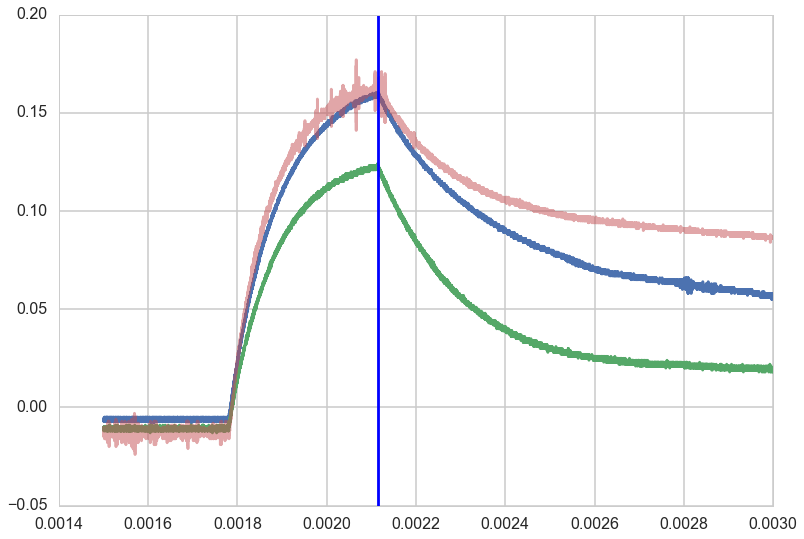

In [91]:
tree = mds.Tree('rsx', 16670)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current_short_oscillation = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

tree = mds.Tree('rsx', 17300)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current_long_oscillation = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

tree = mds.Tree('rsx', 15557)
bias_current_node = tree.getNode(bias_current_node_name)
bias_current_data = bias_current_node.getData()
bias_current_no_oscillation = np.asarray(bias_current_data.getValue())
bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3

time_slice = slice(30000, 60000)
plt.plot(bias_current_time[time_slice], bias_current_short_oscillation[time_slice])
plt.plot(bias_current_time[time_slice], bias_current_long_oscillation[time_slice])
plt.plot(bias_current_time[time_slice], bias_current_no_oscillation[time_slice], alpha=0.5)
plt.axvline(0.002115)

print bias_current_time[42300]

### The crowbar time is very reproducible across shots from the whole range

### The crowbar occurs at $t=0.002115 s$ or index 42300

## Now look at the fft of windows up to index 42300

In [54]:
tree = mds.Tree('rsx', 16670)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_short_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3
tree = mds.Tree('rsx', 17300)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_long_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3
tree = mds.Tree('rsx', 15557)
fiducial_node = tree.getNode(fiducial_a_node_name)
fiducial_data = fiducial_node.getData()
fiducial_no_oscillation = np.asarray(fiducial_data.getValue())
fiducial_time = np.asarray(fiducial_data.getDimensions()[0])*1e-3

In [55]:
window_short_oscillation = fiducial_short_oscillation[35500:42300]
window_long_oscillation = fiducial_long_oscillation[35500:42300]
window_no_oscillation = fiducial_no_oscillation[35500:42300]

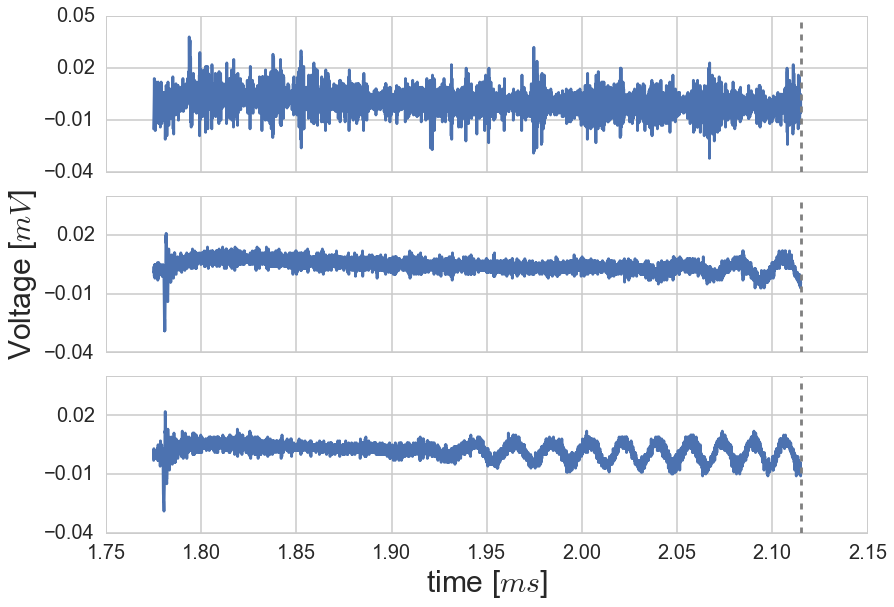

In [154]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
axes[0].plot(fiducial_time[35500:42300]*1e3, fiducial_no_oscillation[35500:42300])
axes[1].plot(fiducial_time[35500:42300]*1e3, fiducial_short_oscillation[35500:42300])
axes[2].plot(fiducial_time[35500:42300]*1e3, fiducial_long_oscillation[35500:42300])
axes[0].axvline(0.002115*1e3, color='grey', linestyle='--')
axes[1].axvline(0.002115*1e3, color='grey', linestyle='--')
axes[2].axvline(0.002115*1e3, color='grey', linestyle='--')
axes[2].set_xlabel(r'time [$ms$]', fontsize=30)
#axes[0].set_ylabel(r'Voltage [$mV$]', fontsize=30)
axes[1].set_ylabel(r'Voltage [$mV$]', fontsize=30)
#axes[2].set_ylabel(r'Voltage [$mV$]', fontsize=30)
axes[0].set_yticks(axes[0].get_yticks()[::3])
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout(h_pad=0.1)
plt.show()

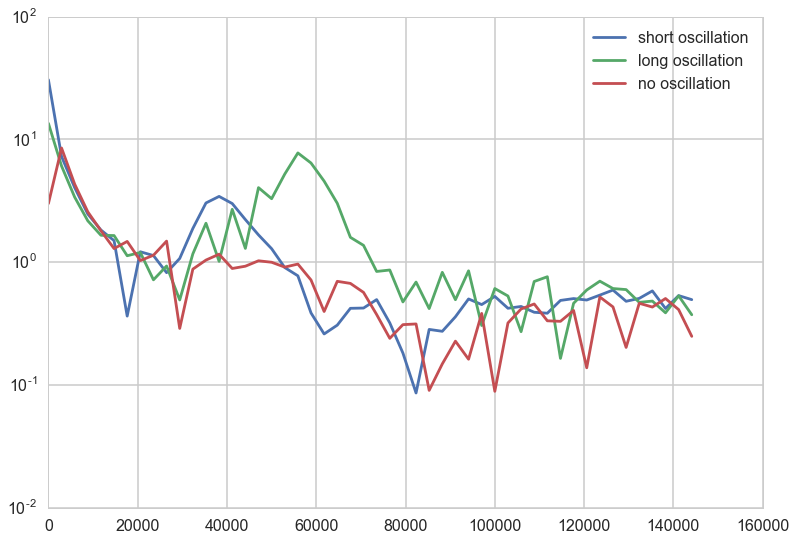

In [56]:
size = window_short_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+50], np.abs(fft.fftshift(fft.fft(window_short_oscillation))[midpoint:midpoint+50]), label='short oscillation')
plt.semilogy(freqs[midpoint:midpoint+50], np.abs(fft.fftshift(fft.fft(window_long_oscillation))[midpoint:midpoint+50]), label='long oscillation')
plt.semilogy(freqs[midpoint:midpoint+50], np.abs(fft.fftshift(fft.fft(window_no_oscillation))[midpoint:midpoint+50]), label='no oscillation')
plt.legend()

In [57]:
window_short_oscillation = fiducial_short_oscillation[25500:42300]
window_long_oscillation = fiducial_long_oscillation[25500:42300]
window_no_oscillation = fiducial_no_oscillation[25500:42300]

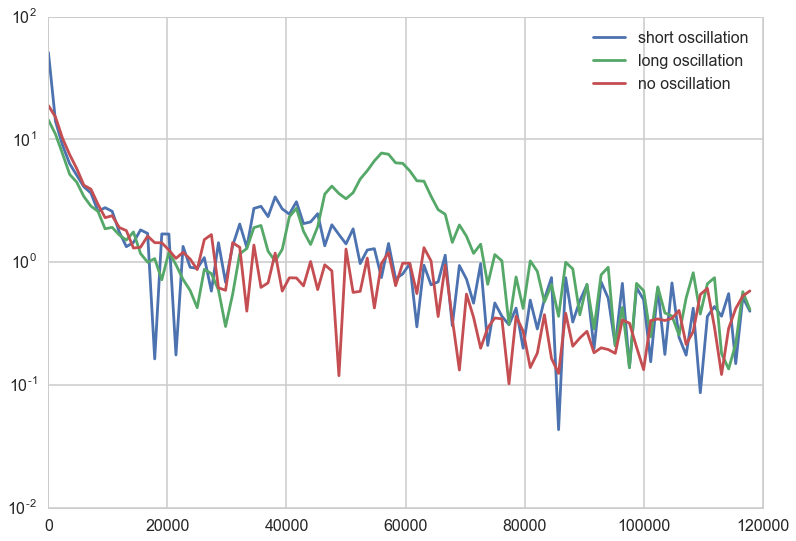

In [58]:
size = window_short_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2
plt.semilogy(freqs[midpoint:midpoint+100], np.abs(fft.fftshift(fft.fft(window_short_oscillation))[midpoint:midpoint+100]), label='short oscillation')
plt.semilogy(freqs[midpoint:midpoint+100], np.abs(fft.fftshift(fft.fft(window_long_oscillation))[midpoint:midpoint+100]), label='long oscillation')
plt.semilogy(freqs[midpoint:midpoint+100], np.abs(fft.fftshift(fft.fft(window_no_oscillation))[midpoint:midpoint+100]), label='no oscillation')
plt.legend()

In [59]:
1/0.00002195

45558.08656036446

## To get a quantitive measure we integrate the spectral power for two standard deviations of period measurements around the gyration period

In [60]:
connection = sqlite3.connect('shots.db')
connection.row_factory = sqlite3.Row
cursor = connection.cursor()
cursor.execute('SELECT shot, period FROM Shots WHERE shot=15557 OR shot=16670 OR shot=17300')
shots = cursor.fetchall()

periods = np.zeros(3)
for shot in shots:
    if shot['shot'] == 15557:
        index = 0
    if shot['shot'] == 16670:
        index = 1
    if shot['shot'] == 17300:
        index = 2
    periods[index] = shot['period']

In [61]:
frequencies = 1/periods

In [62]:
std = cleaned_periods.std()

In [63]:
std_frequencies = cleaned_frequencies.std()

In [64]:
std_frequencies

8386.4338684326958

In [65]:
size = window_short_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))

range_no_oscillation = np.where(np.logical_and(frequencies[0] - std_frequencies <= freqs, freqs <= frequencies[0] + std_frequencies))
range_short_oscillation = np.where(np.logical_and(frequencies[1] - std_frequencies <= freqs, freqs <= frequencies[1] + std_frequencies))
range_long_oscillation = np.where(np.logical_and(frequencies[2] - std_frequencies < freqs, freqs <= frequencies[2] + std_frequencies))

In [66]:
freqs[range_no_oscillation]

array([ 36904.76147349,  38095.23765005,  39285.71382662,  40476.19000318,
        41666.66617975,  42857.14235631,  44047.61853287,  45238.09470944,
        46428.570886  ,  47619.04706257,  48809.52323913,  49999.9994157 ,
        51190.47559226,  52380.95176882])

## There are clear differences in the integrated areas below the curves for the different classes of shots.

### N.B. the period determined in Jason's script does not correspond to the middle of the spectral peak. This might be because the oscillation is not truely sinsoidal, i.e. is made of a smear of frequencies and the gryration period varies over time

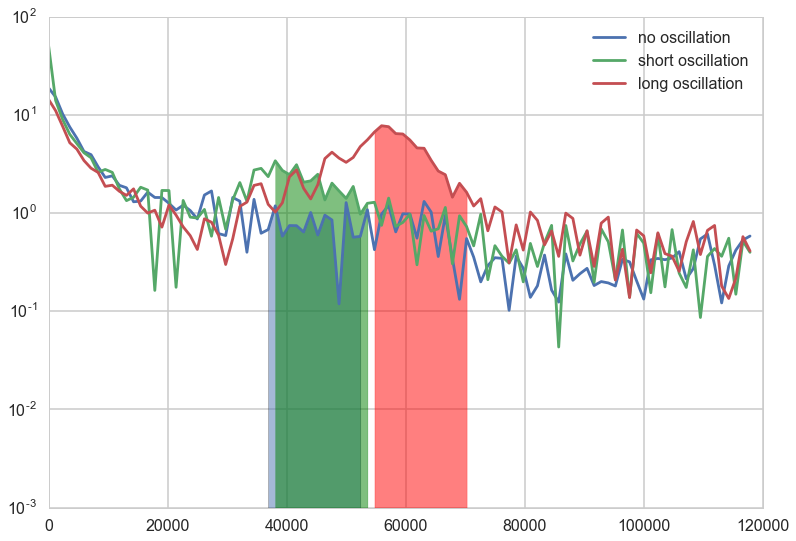

In [67]:
size = window_short_oscillation.size
freqs = fft.fftshift(fft.fftfreq(size, d=fiducial_time[1]-fiducial_time[0]))
midpoint = size/2

no_oscillation_fft = np.abs(fft.fftshift(fft.fft(window_no_oscillation)))
short_oscillation_fft = np.abs(fft.fftshift(fft.fft(window_short_oscillation)))
long_oscillation_fft = np.abs(fft.fftshift(fft.fft(window_long_oscillation)))

plt.semilogy(freqs[midpoint:midpoint+100], no_oscillation_fft[midpoint:midpoint+100], label='no oscillation')
plt.fill_between(freqs[range_no_oscillation], no_oscillation_fft[range_no_oscillation], 1e-3, alpha=0.5)
plt.semilogy(freqs[midpoint:midpoint+100], short_oscillation_fft[midpoint:midpoint+100], label='short oscillation')
plt.fill_between(freqs[range_short_oscillation], short_oscillation_fft[range_short_oscillation], 1e-3, alpha=0.5, color='g')
plt.semilogy(freqs[midpoint:midpoint+100], long_oscillation_fft[midpoint:midpoint+100], label='long oscillation')
plt.fill_between(freqs[range_long_oscillation], long_oscillation_fft[range_long_oscillation], 1e-3, alpha=0.5, color='r')
plt.legend()

In [68]:
from scipy.integrate import cumtrapz

### Integrated spectral power

In [69]:
cumtrapz(no_oscillation_fft[range_no_oscillation], freqs[range_no_oscillation])[0]

1107.1681846933579

In [70]:
cumtrapz(short_oscillation_fft[range_short_oscillation], freqs[range_short_oscillation])[0]

3636.5403590525925

In [71]:
cumtrapz(long_oscillation_fft[range_long_oscillation], freqs[range_long_oscillation])[0]

8572.8065306331046

## The units are bit meaning less. For one the spectral density depends on the arbritaritly choosen lenght of the time window. Also I have to look up how the amplitude of fourier transform relates to power.

In [72]:
import scipy.signal

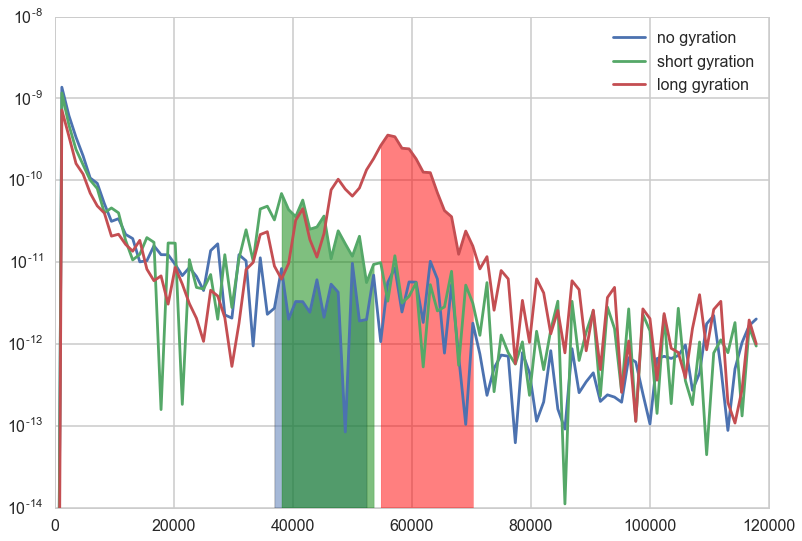

In [73]:
fs = 1/(fiducial_time[1] - fiducial_time[0])

freqs, no_oscillation_fft = scipy.signal.periodogram(window_no_oscillation, fs)
freqs, short_oscillation_fft = scipy.signal.periodogram(window_short_oscillation, fs)
freqs, long_oscillation_fft = scipy.signal.periodogram(window_long_oscillation, fs)

range_no_oscillation = np.where(np.logical_and(frequencies[0] - std_frequencies <= freqs, freqs <= frequencies[0] + std_frequencies))
range_short_oscillation = np.where(np.logical_and(frequencies[1] - std_frequencies <= freqs, freqs <= frequencies[1] + std_frequencies))
range_long_oscillation = np.where(np.logical_and(frequencies[2] - std_frequencies < freqs, freqs <= frequencies[2] + std_frequencies))

plt.semilogy(freqs[:100], no_oscillation_fft[:100], label='no gyration')
plt.semilogy(freqs[:100], short_oscillation_fft[:100], label='short gyration')
plt.semilogy(freqs[:100], long_oscillation_fft[:100], label='long gyration')
plt.fill_between(freqs[range_no_oscillation], no_oscillation_fft[range_no_oscillation], 1e-14, alpha=0.5)
#plt.semilogy(freqs[midpoint:midpoint+100], short_oscillation_fft[midpoint:midpoint+100], label='short oscillation')
plt.fill_between(freqs[range_short_oscillation], short_oscillation_fft[range_short_oscillation], 1e-14, alpha=0.5, color='g')
#plt.semilogy(freqs[midpoint:midpoint+100], long_oscillation_fft[midpoint:midpoint+100], label='long oscillation')
plt.fill_between(freqs[range_long_oscillation], long_oscillation_fft[range_long_oscillation], 1e-14, alpha=0.5, color='r')
plt.legend()
plt.ylim((1e-14, 1e-8))
plt.show()

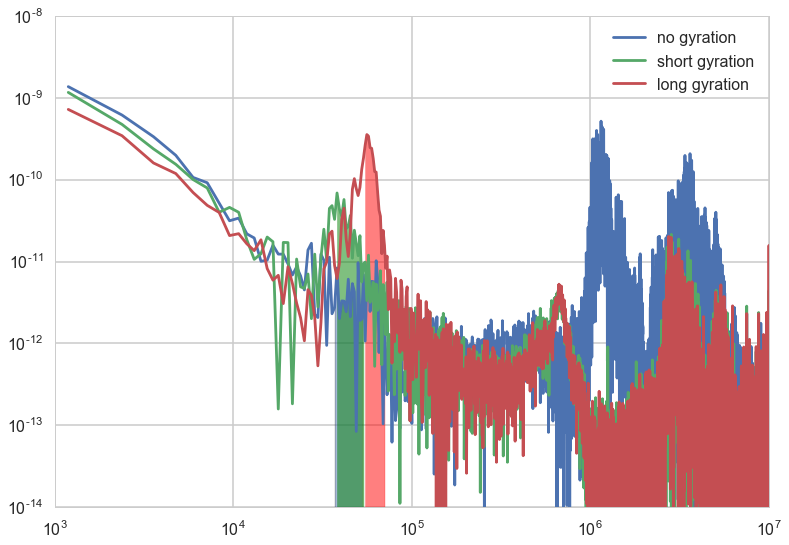

In [74]:
fs = 1/(fiducial_time[1] - fiducial_time[0])

freqs, no_oscillation_fft = scipy.signal.periodogram(window_no_oscillation, fs)
freqs, short_oscillation_fft = scipy.signal.periodogram(window_short_oscillation, fs)
freqs, long_oscillation_fft = scipy.signal.periodogram(window_long_oscillation, fs)

range_no_oscillation = np.where(np.logical_and(frequencies[0] - std_frequencies <= freqs, freqs <= frequencies[0] + std_frequencies))
range_short_oscillation = np.where(np.logical_and(frequencies[1] - std_frequencies <= freqs, freqs <= frequencies[1] + std_frequencies))
range_long_oscillation = np.where(np.logical_and(frequencies[2] - std_frequencies < freqs, freqs <= frequencies[2] + std_frequencies))

plt.loglog(freqs[:], no_oscillation_fft[:], label='no gyration')
plt.loglog(freqs[:], short_oscillation_fft[:], label='short gyration')
plt.loglog(freqs[:], long_oscillation_fft[:], label='long gyration')
plt.fill_between(freqs[range_no_oscillation], no_oscillation_fft[range_no_oscillation], 1e-14, alpha=0.5)
#plt.semilogy(freqs[midpoint:midpoint+100], short_oscillation_fft[midpoint:midpoint+100], label='short oscillation')
plt.fill_between(freqs[range_short_oscillation], short_oscillation_fft[range_short_oscillation], 1e-14, alpha=0.5, color='g')
#plt.semilogy(freqs[midpoint:midpoint+100], long_oscillation_fft[midpoint:midpoint+100], label='long oscillation')
plt.fill_between(freqs[range_long_oscillation], long_oscillation_fft[range_long_oscillation], 1e-14, alpha=0.5, color='r')
plt.legend()
plt.ylim((1e-14, 1e-8))
plt.show()

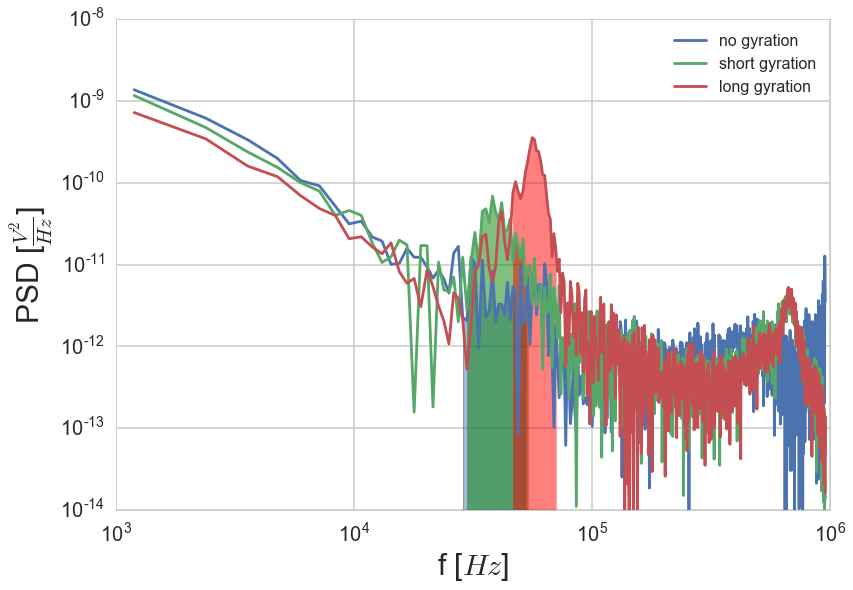

In [160]:
fs = 1/(fiducial_time[1] - fiducial_time[0])

freqs, no_oscillation_fft = scipy.signal.periodogram(window_no_oscillation, fs)
freqs, short_oscillation_fft = scipy.signal.periodogram(window_short_oscillation, fs)
freqs, long_oscillation_fft = scipy.signal.periodogram(window_long_oscillation, fs)

range_no_oscillation = np.where(np.logical_and(frequencies[0] - 2*std_frequencies <= freqs, freqs <= frequencies[0] + std_frequencies))
range_short_oscillation = np.where(np.logical_and(frequencies[1] - 2*std_frequencies <= freqs, freqs <= frequencies[1] + std_frequencies))
range_long_oscillation = np.where(np.logical_and(frequencies[2] - 2*std_frequencies < freqs, freqs <= frequencies[2] + std_frequencies))

limit=800
plt.loglog(freqs[:limit], no_oscillation_fft[:limit], label='no gyration')
plt.loglog(freqs[:limit], short_oscillation_fft[:limit], label='short gyration')
plt.loglog(freqs[:limit], long_oscillation_fft[:limit], label='long gyration')
plt.fill_between(freqs[range_no_oscillation], no_oscillation_fft[range_no_oscillation], 1e-14, alpha=0.5)
#plt.semilogy(freqs[midpoint:midpoint+100], short_oscillation_fft[midpoint:midpoint+100], label='short oscillation')
plt.fill_between(freqs[range_short_oscillation], short_oscillation_fft[range_short_oscillation], 1e-14, alpha=0.5, color='g')
#plt.semilogy(freqs[midpoint:midpoint+100], long_oscillation_fft[midpoint:midpoint+100], label='long oscillation')
plt.fill_between(freqs[range_long_oscillation], long_oscillation_fft[range_long_oscillation], 1e-14, alpha=0.5, color='r')
plt.legend()
plt.ylim((1e-14, 1e-8))
plt.xlabel(r'f [$Hz$]', fontsize=30)
plt.ylabel(r'PSD [$\frac{V^2}{Hz}$]', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

### Note order of magnitude differences in integrated spectral density

In [76]:
cumtrapz(no_oscillation_fft[range_no_oscillation], freqs[range_no_oscillation])[0]

6.5804462630487924e-09

In [77]:
cumtrapz(short_oscillation_fft[range_short_oscillation], freqs[range_short_oscillation])[0]

6.6957706783840374e-08

In [78]:
cumtrapz(long_oscillation_fft[range_long_oscillation], freqs[range_long_oscillation])[0]

3.6945442965980319e-07